# BIFOLD Aqtivate workshop - Neural networks introduction

In [47]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np
device = torch.device('cpu')
#device = torch.device('cuda') # Uncomment this to run on GPU



In [2]:
def visualize_decision_boundary(model,x_data, y_data, x_min=-1, x_max=2):
    assert x_data.shape[1]==2, "Can Only plot decision boundary for 2D Data"
    xx1, xx2 = torch.meshgrid(torch.arange(x_min, x_max, 0.1),
                               torch.arange(x_min, x_max, 0.1), indexing="ij")

    # Flatten and concatenate the meshgrid points
    grid_points = torch.stack([xx1.ravel(), xx2.ravel()], dim=1)

    # Apply the model to the meshgrid points to get class probabilities
    with torch.no_grad():
        Z = torch.round(model(grid_points.to(device)).view(xx1.shape))

    # Plot the decision boundary and the data points
    plt.contourf(xx1, xx2, Z, alpha=0.9)
    plt.scatter(x_data[:, 0], x_data[:, 1], c=y_data, marker='o', edgecolors='k')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title('Decision Boundary Visualization')
    plt.colorbar()
    plt.show()


# XOR Problem

In [3]:
class XORData(Dataset):
    def __init__(self):
        super().__init__()
        self.x = torch.tensor([[0,0],[0,1],[1,0],[1,1]]).float()
        self.y = torch.tensor([[0],[1],[1],[0]]).float()
        self.N = 4
    
    def __len__(self):
        return self.N

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [53]:
#Design our NN model class in pytorch
class LinearModel(nn.Module):

    def __init__(self, D_in=2, D_out = 1):
        # D_in is input dimension; D_out is output dimension.
        super(LinearModel, self).__init__()        
        self.w = torch.nn.Parameter(torch.randn(D_in, D_out, requires_grad=True))
        self.b = torch.nn.Parameter(torch.randn(1, D_out, requires_grad=True))
        
    def forward(self, x):
        return torch.matmul(x, self.w) + self.b
    
class MLP(nn.Module):
    def __init__(self, D_in=2, H =2, D_out = 1):
        # D_in is input dimension; H is hidden dimension; D_out is output dimension.
        super(MLP, self).__init__()
        
        self.mlp = nn.Sequential(
                    nn.Linear(D_in, H),
                    nn.Sigmoid(),
                    nn.Linear(H, D_out),
                    nn.Sigmoid(),
                )

    def forward(self, x):
        return self.mlp(x)

In [54]:
def set_up_model(linear=True):
    # Set seed for reproducability
    torch.manual_seed(2)
    # Initialize model
    if linear:
        # learning rate
        lr = 0.05 
        model = LinearModel().to(device)
    else:
        # learning rate
        lr = 0.5 
        model = MLP().to(device)
    
    # Construct loss function and Optimizer. The call to model.parameters()
    # in the SGD constructor will contain the learnable parameters of the model
    criterion = nn.MSELoss(reduction='sum') 
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    return model, criterion, optimizer

def get_XOR_dataloader():
    # Initialize Dataset
    dataset = XORData()
    dataloader = DataLoader(dataset, shuffle=True,batch_size=2)
    return dataloader

In [55]:
#Training cycle: forward, loss, backward, step
def train(dataloader, linear=True):
    model, criterion, optimizer = set_up_model(linear)
    
    visualize_decision_boundary(model,dataloader.dataset.x,dataloader.dataset.y)
    losses = []
    for epoch in range(4000):
        epoch_loss= 0
        for x_data, y_data in dataloader:
            optimizer.zero_grad()  # zero gradients

            y_pred = model(x_data.to(device))  # 1. forward
            loss = criterion(y_pred, y_data.to(device))  # 2. loss
            loss.backward()  # 3. backward
            optimizer.step()  # 4. update
            epoch_loss += loss.item()
        losses.append(epoch_loss)

    visualize_decision_boundary(model,dataloader.dataset.x,dataloader.dataset.y)
    plt.plot(losses)

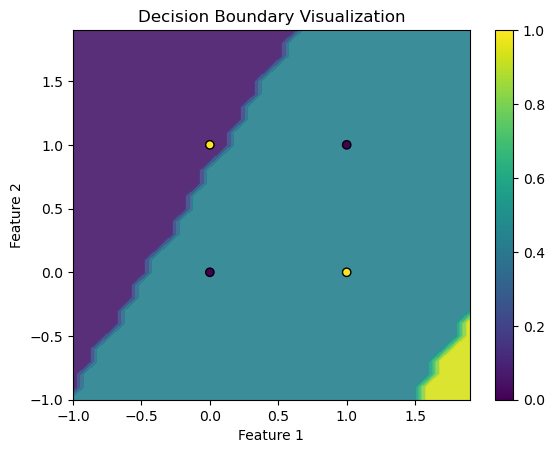

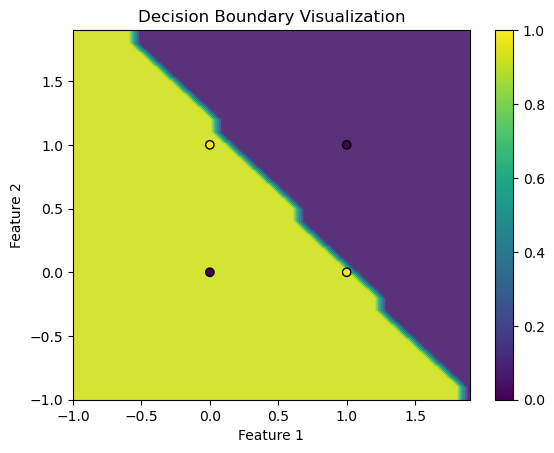

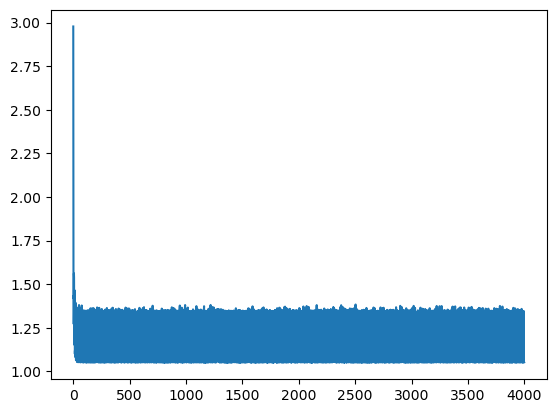

In [56]:
dataloader = get_XOR_dataloader()
train(dataloader,linear=True)

## Manually training
Your task is to implement backpropagation manually for the provided linear network (LinearModel). You'll update the weights of the network using the computed gradients.

The computed gradients `dw` and `db` should match the gradients computed via autograd.

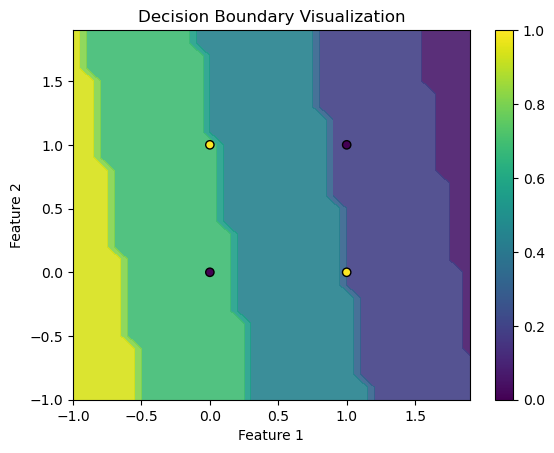

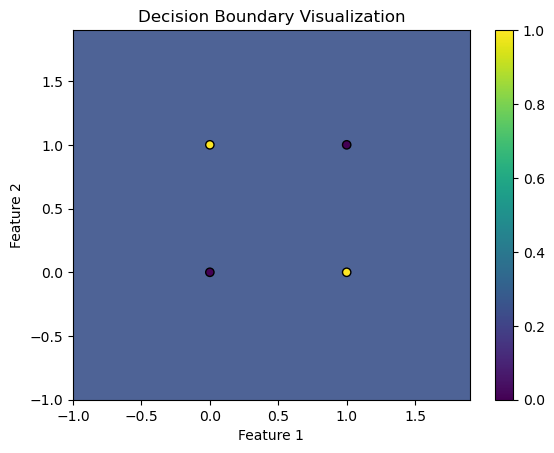

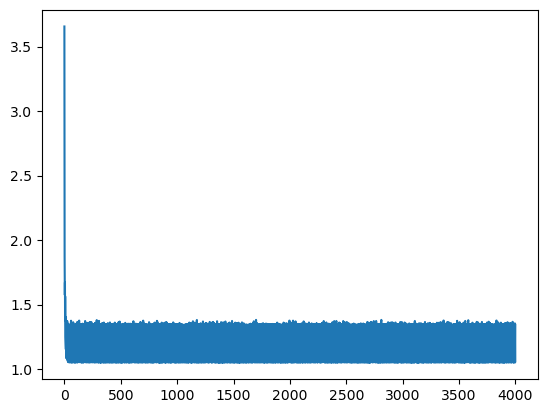

In [57]:

def manuel_train(dataloader):
    model = LinearModel().to(device)
    lr = 0.05
    visualize_decision_boundary(model,dataloader.dataset.x,dataloader.dataset.y)
    losses = []
    for epoch in range(4000):
        epoch_loss= 0
        for x_data, y_data in dataloader:
            model.zero_grad()
            y_pred = model(x_data.to(device)) 
            
            # Compute loss (Mean Squared Error)
            loss = torch.sum((y_pred - y_data)**2)
            
            # Compute the derivative with respect to w and b
            # TODO YOUR CODE HERE
            dw = None
            db = None 
            
            # Update weights manually
            
            
            
            
            
            loss.backward()
            assert( torch.sum((dw -model.w.grad)**2) < 0.0001), "Gradient for Weight does not match Pytorch gradients" 
            assert( torch.sum((db -model.b.grad)**2) < 0.0001), "Gradient for Bias does not match Pytorch gradients" 
            epoch_loss += loss.item()
        losses.append(epoch_loss)

    visualize_decision_boundary(model,dataloader.dataset.x,dataloader.dataset.y)
    plt.plot(losses)

manuel_train(dataloader)

## Non Linear Network for X-OR problem


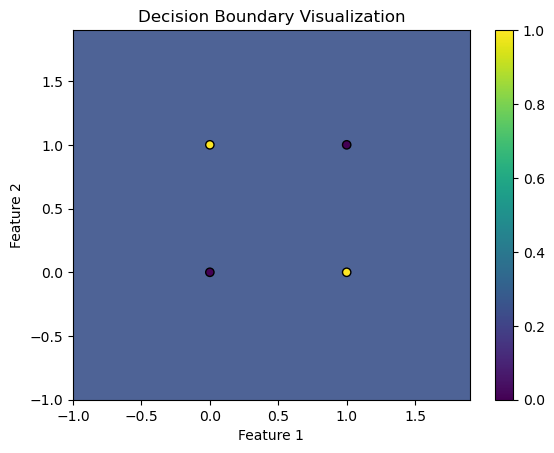

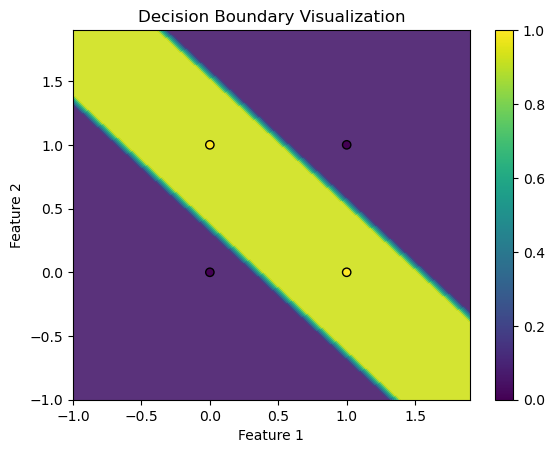

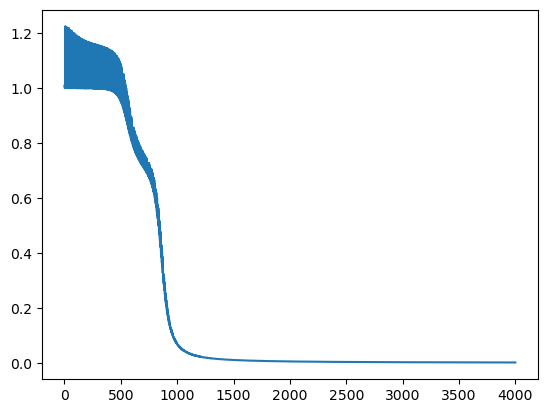

In [58]:
   
dataloader = get_XOR_dataloader()
train(dataloader,linear=False)

# Simple Regression Problem
In this exercise, we try to solve a toy regression problem with simple feed forward neural networks.



In [10]:
from sklearn.datasets import load_diabetes, fetch_california_housing
from sklearn.model_selection import train_test_split
class PytorchToyData(Dataset):
    def __init__(self, dataset="diabetes", train=True):
        super().__init__()
        if dataset == "diabetes":
            data = load_diabetes()
        elif dataset == "housing":
            data = fetch_california_housing()
        X_train, X_test, y_train, y_test = train_test_split(data.data, data.target, test_size=0.1, random_state=13)
        if train:
            self.x = torch.tensor(X_train)
            self.y = torch.tensor(y_train).view(-1,1)
        else:
            self.x = torch.tensor(X_test)
            self.y = torch.tensor(y_test).view(-1,1)
        self.N = self.x.shape[0]
        
    def __len__(self):
        return self.N

    def __getitem__(self, idx):
        return self.x[idx].float(), self.y[idx].float()
    

In [11]:
dataset = "diabetes"
#dataset = "housing"
train_data = PytorchToyData(dataset)
test_data = PytorchToyData(dataset,train=False)
batch_size=128
train_loader = DataLoader(train_data, shuffle=True,batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle=False,batch_size=batch_size)

## Creating the Neural Network

The objective of this task is to implement a feedforward neural network with a variable number of hidden layers (depth). You will construct a neural network architecture with ReLU activation functions and train it for regression tasks.

You need to complete the implementation of the following class:

`RegressionNetwork(nn.Module)`: This class defines the neural network architecture. It should accept the input dimension (D_in), output dimension (D_out), hidden dimension (H), and the number of hidden layers (depth).
The layers should be initialized in the `__init__` function, while the `forward` function should implement the forward pass. As this is a `nn.Module` pytorch takes care of the backwards pass.


In [12]:
class RegressionNetwork(nn.Module):
    def __init__(self, D_in, D_out, H, depth=2):
        super().__init__()
        # TODO YOUR CODE HERE
        
        
    def forward(self, x):
        # TODO YOUR CODE HERE
        result = None
        return result

## Training the Model
Implement both the training and evaluation loop for a single Epoch.

**Instructions:**

The objective of this task is to familiarize yourself with the process of training and evaluating a (deep) neural network. You will implement both the training and evaluation loops necessary to train a regression model and evaluate its performance on a given dataset.
You need to complete the implementation of the following functions:

`loss_function(y_pred, y_data)`: This function should compute the Regression loss between the predicted and actual values (e.g. MSE or MAE).

`train_epoch(model, train_loader, optimizer)`: This function should implement the training loop for a single epoch. It should iterate over the training dataset, compute the predictions of the model, calculate the loss, perform backpropagation, and update the model's parameters using the provided optimizer. It should return the average loss per epoch.

`test_epoch(model, test_loader)`: This function should implement the evaluation loop for a single epoch. It should iterate over the test dataset, compute the predictions of the model, calculate the loss, and return the average loss over the entire test dataset.

`init_model(D_in, D_out, H, depth, lr)`: This function should initializes the regression model with the given hyperparameter and setup an optimizer.

**Provided Functions:**

`train_model(model, optimizer, train_loader, test_loader, N_epochs=200)`: Trains the model for multiple epochs using the provided training and test data loaders.

In [13]:
def loss_function(y_pred,y_data):
    # TODO YOUR CODE HERE
    return None

def test_epoch(model, test_loader):
    error = 0
    with torch.no_grad():
        # TODO YOUR CODE HERE
        pass
    
    return error / len(test_loader.dataset)

def train_epoch(model, train_loader, optimizer):
    train_loss = 0
    # TODO YOUR CODE HERE
    
    
    return train_loss / len(train_loader.dataset)

def init_model(D_in, D_out, H=32, depth=2, lr=0.01):
    # TODO YOUR CODE HERE
    model, optimizer  = None, None
    
    return model, optimizer 


def train_model(model, optimizer, train_loader, test_loader, N_epochs=200):
    train_losses = []
    test_losses = []
    for i in range(N_epochs):
        train_losses.append(train_epoch(model, train_loader, optimizer))
        test_losses.append(test_epoch(model, test_loader))
    return train_losses, test_losses
    

## Exploring Hyperparameters and Observing Changes

Now that we have implemented our neural network and training procedures, it's time to explore the impact of hyperparameters on our model's performance. Hyperparameters such as hidden layer dimension (H), depth of the network (depth), and learning rate (lr) can significantly influence the training process and final performance.
Set Hyperparameters

Let's set some initial hyperparameters:

    Hidden Layer Dimension (H): 128
    Depth of the Network (depth): 2
    Learning Rate (lr): 0.0000001
    Number of Epochs (N_epochs): 200

Tasks:
    Initialize the model with the provided hyperparameters.
    Train the model.
    Visualize the training and testing errors across epochs.
    Observe the impact of hyperparameters on the final training and testing errors.

By experimenting with different values for these hyperparameters, you'll gain insights into how they affect the model's performance and how to tune them for optimal results. Let's dive in and start experimenting!

Final Train Error: 2834.281781328715, Test Error: 3310.069791666667


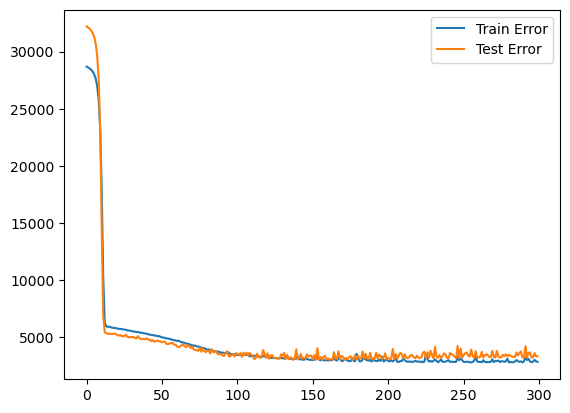

In [14]:


# Set Hyperparameter
H = 128
depth = 2
lr = 0.000001
D_in=train_loader.dataset[0][0].shape[0]
D_out = 1
N_epochs = 300

# Initialize Model
model, optimizer = init_model(D_in=D_in,D_out=D_out, H=H, depth=depth, lr=lr)

#Train Model
train_losses, test_losses = train_model(model, optimizer, train_loader, test_loader,N_epochs=N_epochs)

# Visualize Train and Test Error
plt.plot(train_losses, label="Train Error")
plt.plot(test_losses, label="Test Error")
plt.legend()
print(f"Final Train Error: {train_losses[-1]}, Test Error: {test_losses[-1]}")

## Visualize Model Prediction

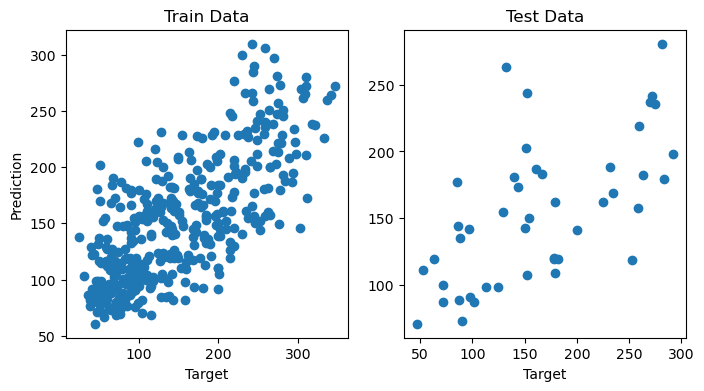

In [15]:
fig, ax = plt.subplots(1,2,figsize=(8,4))
pred_y_test = model(test_data.x.float()).detach()
pred_y_train = model(train_data.x.float()).detach()
ax[0].scatter(train_data.y,pred_y_train)
ax[1].scatter(test_data.y,pred_y_test)
ax[0].set_title("Train Data")
ax[1].set_title("Test Data")
ax[0].set_xlabel("Target")
ax[1].set_xlabel("Target")
ax[0].set_ylabel("Prediction")
plt.show()

# Bonus MNIST Classification

MNIST is a widely used dataset in the field of machine learning and computer vision. It consists of a collection of 28x28 grayscale images of handwritten digits (0 through 9) along with their corresponding labels. The dataset is often used as a benchmark for testing and comparing various machine learning algorithms, particularly in the task of digit recognition.

**One-Hot-Encoding for Classification**

In classification tasks, one-hot encoding is commonly used to represent the class labels, where only one element is activated (set to 1) while the others are 0. This representation enables the neural network to learn and predict the correct class probabilities for each input.

**Cross Entropy Loss**

While Mean Squared Error (MSE) loss is commonly used for regression tasks, Cross-Entropy Loss, is preferred for classification problems. It measures the dissimilarity between the predicted probability distribution and the true distribution of class labels.


**Softmax Activation Function**

Softmax is a commonly used activation function in the output layer of neural networks for multi-class classification tasks. It converts the raw output scores (logits) of the network into a probability distribution over multiple classes:
$$p_i = \frac{e^{z_i}}{\sum_{j=1}^{M}e^{z_j}}$$

Where:
* $p_i$ is the probability of class i,
* $z_i$ is the raw score (logit) for class i,
* $M$ is the total number of classes.

Softmax ensures that the output probabilities sum up to 1, making it interpretable as a probability distribution.



In [16]:
from torchvision import datasets, transforms
transform = transforms.Compose( [transforms.ToTensor(), torch.flatten])
target_transform = transforms.Compose([
                                 lambda x:torch.LongTensor([x]),
                                 lambda x:torch.nn.functional.one_hot(x,10),
                                 lambda x: x.float()[0]])

mnist_train = datasets.MNIST('./data',train=True, download=True, transform=transform,target_transform=target_transform)
mnist_test = datasets.MNIST('./data',train=False, download=True, transform=transform,target_transform=target_transform)

train_loader = torch.utils.data.DataLoader(dataset=mnist_train, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=mnist_test, batch_size=batch_size, shuffle=False)


**Bonus Task:**
Compare the MSE and Cross Entropy Loss for the simple Linear Model on the MNIST Classification task

Final Train Error: 0.36616504424413043, Test Error: 0.33408986535072327


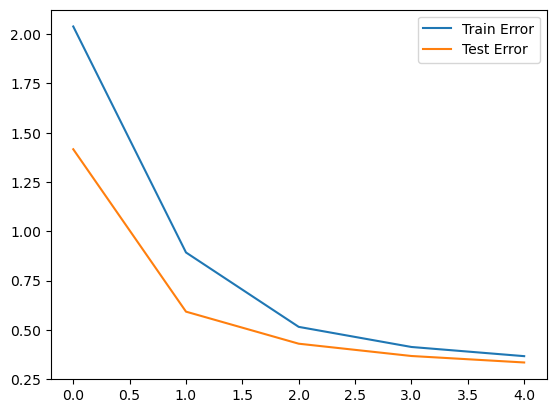

In [59]:
D_in=train_loader.dataset[0][0].shape[0]
D_out = 10
N_epochs = 5
lr = 0.0001
# Initialize Model
model, optimizer = init_model(D_in=D_in,D_out=D_out, H=H, depth=depth, lr=lr)
#Train Model
train_losses, test_losses = train_model(model, optimizer, train_loader, test_loader,N_epochs=N_epochs)

# Visualize Train and Test Error
plt.plot(train_losses, label="Train Error")
plt.plot(test_losses, label="Test Error")
plt.legend()
print(f"Final Train Error: {train_losses[-1]}, Test Error: {test_losses[-1]}")

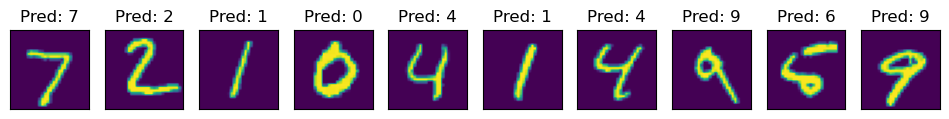

In [52]:
fig, ax = plt.subplots(1,10,figsize=(12,4))

for i in range(10):
    
    ax[i].imshow(mnist_test[i][0].reshape(28,28))
    pred = torch.nn.functional.softmax(model(mnist_test[i][0]).detach().cpu(),dim=-1)
    ax[i].set_title(f"Pred: {torch.argmax(pred).item()}")
    ax[i].tick_params(top=False, bottom=False, left=False, right=False, labelleft=True, labelbottom=True)
    plt.setp(ax[i].get_xticklabels(), visible=False)
    plt.setp(ax[i].get_yticklabels(), visible=False)
    